In [1]:
# Python 3.7

import sys
sys.path.append('../GI1_v0.2.1')
sys.path.append('../GI1_v0.2.1/PLOT/')
sys.path.append('../GI1_additions')


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import green as g
import source as s
import processing as proc
import parameters
import time
import random
from correlation_random import *
from correlation_function import *
from correlation_field import *
from kernels import *
from adsrc import *
from earthquakes import *

# The following are newly added, as compared to the original GI code.
from generate_random_signals import *
from specshift import *

%matplotlib inline

In [2]:
mpl.rcParams['figure.figsize'] = [20, 10]

In [3]:
use_saved_data = True

#####################################################
if(use_saved_data is False):
    
    # Check the station and noise-source geometry
    S,indeces=s.space_distribution(plot=1)


    # Re-create the synthetic data.
    ut,traw,cct,t,ccf,f = generate_random_signals(verbose=False,plot=True,save=True,return_cc=True)
#####################################################
else:
    # Alternatively, just load from file
    p=parameters.Parameters()

    # Load "traw" of raw timeseries
    filename = './OUTPUT/raw_synthetics/traw.npy'
    traw = np.load(filename)
    
    # Load raw timeseries
    for i in range(p.Nreceivers):
        filename = './OUTPUT/raw_synthetics/syn_{0}.npy'.format(i)
        if(i==0): # first one, load to get size.
            tmp = np.load(filename)
            [nsamp,nwindows] = np.shape(tmp)
            ut = np.zeros([nsamp,nwindows,p.Nreceivers])
            ut[:,:,i] = tmp
        else:
            ut[:,:,i] = np.load(filename)
    
#     # Load "t" of correlations functions
#     filename = './OUTPUT/correlations_measured/t.npy'
#     tt_corr = np.load(filename)
#     nt = np.size(tt_corr)

#     # Load correlation functions
#     cct = np.zeros([nt,p.Nwindows,p.Nreceivers**2])
#     counter = 0
#     for i in range(p.Nreceivers):
#         for j in range(p.Nreceivers):        
#             filename = "./OUTPUT/correlations_measured/cct_proc_{}_{}.npy".format(i,j)
#             this_corr = np.load(filename)

#             cct[:,:,counter] = this_corr
#             counter += 1
#####################################################


## A quick back-of-the-envelope check of our array dimensions.
### The bandpass filter of our data should be comparable to the wavelengths/frequencies resolveable by the array aperature and station-spacing.

### In general, beamforming can be used on data that with shorter or longer periods than described here. In the case of shorter periods (high frequency), expect aliasing. In the case of longer periods (low frequency), expect a large "blob" or poor resolution.

### The array-response function (not shown here) can be useful to characterize an array, and potentially even deconvolved from the resulting image.

In [4]:

xx = p.x/1000
yy = p.y/1000
dis=[]
for i in range(p.Nreceivers):
    for j in range(p.Nreceivers):
        if(i==j):
            continue
        dis.append( np.sqrt( (xx[i]-xx[j])**2 + (yy[i]-yy[j])**2 ))
print("Average distance = {0:.2f}km".format(np.mean(dis)))
print("At 3km/s, average period for array = {0:.2f}sec".format(np.mean(dis)/3))
print("")

print("Min distance (inter-station) = {0:.2f}km".format(np.min(dis)))
print("At 3km/s, shortest period = {0:.2f}sec".format(np.min(dis)/3))
print("")


print("Max distance (aperture) = {0:.2f}km".format(np.max(dis)))
print("At 3km/s, longest period = {0:.2f}sec".format(np.max(dis)/3))
print("")


print("Signals bandpassed from {0:.2f} to {1:.2f} Hz, {2:.2f} to {3:.2f} seconds".format(p.bp_fmin,p.bp_fmax,1/p.bp_fmax,1/p.bp_fmin))

Average distance = 6.06km
At 3km/s, average period for array = 2.02sec

Min distance (inter-station) = 1.95km
At 3km/s, shortest period = 0.65sec

Max distance (aperture) = 12.33km
At 3km/s, longest period = 4.11sec

Signals bandpassed from 0.30 to 5.70 Hz, 0.18 to 3.33 seconds


## Frequency Domain!

32768


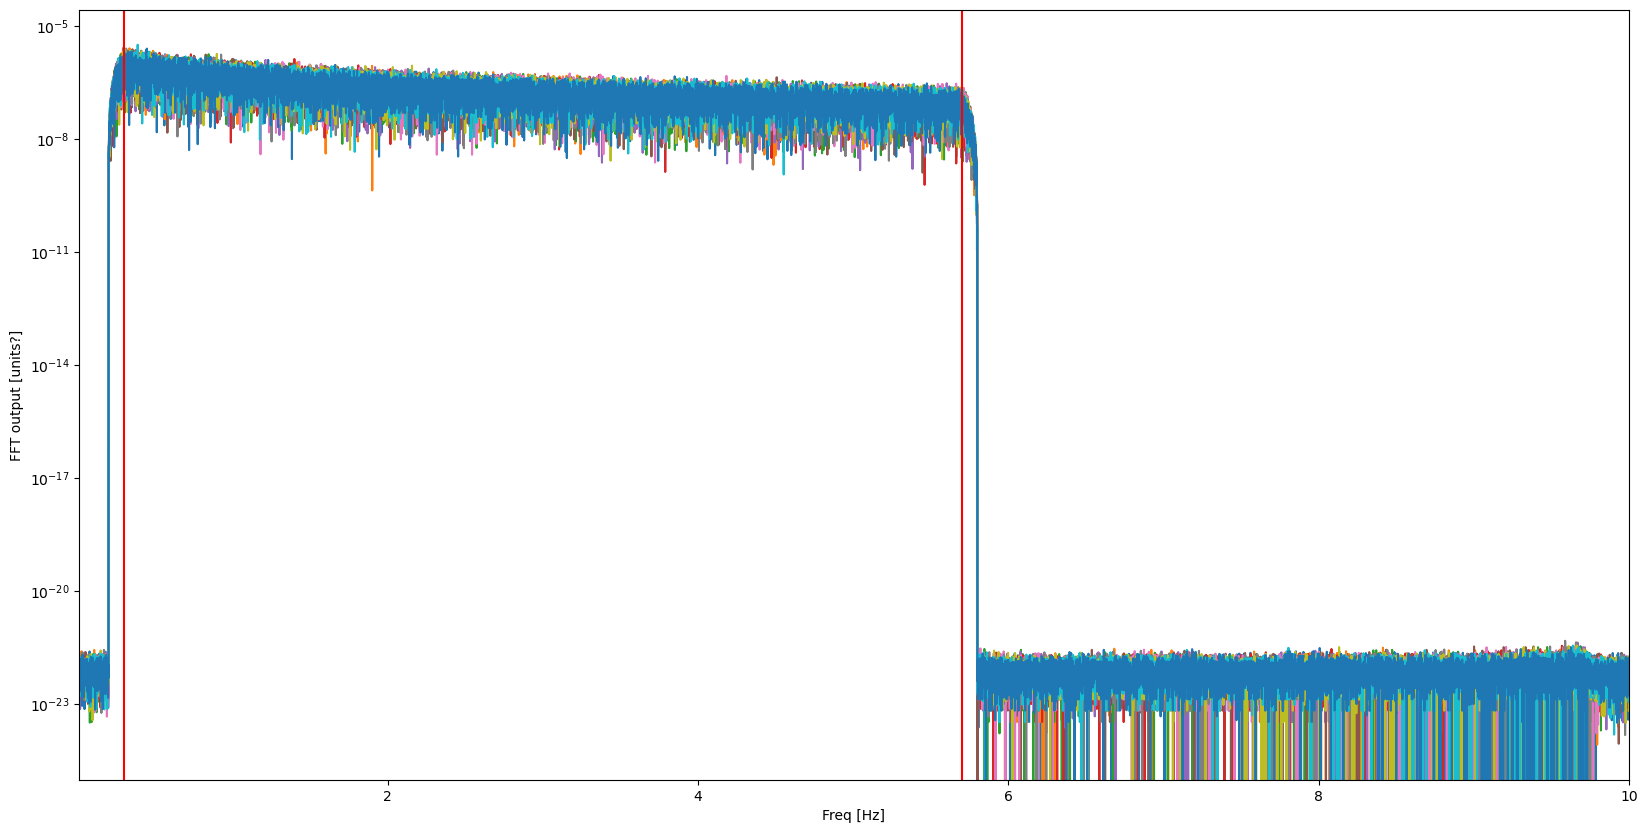

In [5]:
iwin=0
data=ut[:,iwin,:]
npts = np.shape(data)[0]
nsta = np.shape(data)[1]
dt = traw[1]-traw[0]        # or use p.dt

# Define our frequencies
nfft = (2.0**np.ceil(np.log2(npts))).astype(int)
print(nfft)
df=1.0/(2.0*nfft*dt)
# "xf" will be our x-axis; the frequencies that result from our fft()
xf = np.linspace(0.0, 1.0/(2.0*dt), np.int((nfft/2)+1))


# df=1.0/(nfft*dt)
# xf = np.linspace(0.0, 1.0/(dt), np.int((nfft/2)+1))


spectra = np.zeros([np.size(xf),nsta],dtype='complex')
for ii in range(nsta):
     spectra[:,ii] = np.fft.rfft(data[:,ii],n=nfft)
# Our input timeseries is real, so we use rfft().
# rfft() knows that the output is symmetric, and so only returns ~1/2 of the full "nfft" we gave it

# Plot the spectra, just to make sure we're on the right track
plt.semilogy(xf, np.abs(spectra))
plt.xlim([0.01,10])
plt.ylim([10^-9,10^-3])
plt.xlabel('Freq [Hz]')
plt.ylabel('FFT output [units?]')
plt.axvline(p.bp_fmin,color='r')
plt.axvline(p.bp_fmax,color='r')
plt.show()


## Beamform: 

### First set up polar grid and range of frequencies to loop over

In [23]:
#-- Set up a grid of slownesses and azimuths
sl=0.75   # maximum slowness to test. second/km

# Define in polar coordinates, Radius (U for slowness) and Azimuth (Th for theta)
nuU = 200
nuTh = 200
uU  = np.linspace(0,sl,nuU)
uTh  = np.linspace(0,2*np.pi,nuTh)

# meshgrid only needed for plotting later
uUU, uTT = np.meshgrid(uU, uTh)

#-- Set up a range of frequencies
# (do each beamform separately, average at the end)
# num_freqs = 200
# f_min = 0.3
# f_max = 4.7

num_freqs = 100
f_min = 0.3
f_max = 5
target_freqs = np.linspace(f_min,f_max,num_freqs)
# target_periods = np.linspace(20,80,num_periods)

In [24]:
nsta = np.shape(ut)[2]
P=np.zeros([num_freqs,nuU,nuTh])


# To speed things up, let's precompute a library of timeshifts, rather than recompute for each frequency:
tlib=np.zeros([nsta,nuTh,nuU],dtype=float)
for iTh in range(0,nuTh):
        for iU in range(0,nuU):
            tlib[:,iU,iTh] = xx*uU[iU]*np.cos(uTh[iTh]) + yy*uU[iU]*np.sin(uTh[iTh])

                

for ii in range(np.size(target_freqs)):
    #target_f = 1/target_periods[ii]
    target_f = target_freqs[ii]
    idf = (np.abs(xf - target_f)).argmin()

    # Construct a matrix of each station-station correlation
    Rxx=np.zeros([nsta,nsta],dtype=complex)
    for i1 in range(0,nsta):
        for i2 in range(0,nsta):
            Rxx[i1,i2] = np.conj(spectra[idf,i1]) * spectra[idf,i2]


    for iTh in range(0,nuTh):
            for iU in range(0,nuU):
                    timeshifts = tlib[:,iU,iTh]

                    a = np.exp(-1j*2*np.pi*target_f*timeshifts)
                    aconj = np.conj(a)
                    P[ii,iU,iTh] = aconj @ Rxx @ a #/ (aconj @ a)

# Now we average the results from each frequency
P_stack = np.mean(P,axis=0)/num_freqs
P_stack = np.real(P_stack)



In [25]:
#-- Define a plotting function

mpl.rc('font', **{'size':20})
    
def plot_beam_polar(PP, title="Beamform",save=0,savename='none',cmax=0):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, polar = True)
    cmap = plt.get_cmap('inferno')
    #i = plt.pcolor(2*np.pi-UT[::1]+np.pi/2, UR[::1], np.real(P[::1]), cmap=cmap, rasterized=True)
    i = plt.pcolor(uTT, uUU, np.real(PP.T), cmap=cmap, rasterized=True)

#     i = plt.pcolor(np.real(PP), cmap=cmap, rasterized=True)
    
    if(cmax==0):
        cmax=np.max(np.abs(PP))
    cmin=np.min(PP)
    plt.clim(cmin, cmax)
    
    # set title, labels, etc
    plt.title(title)
    
    ax.set_xticks(np.arange(0, 2.0*np.pi, np.pi/2.0))
    ax.set_xticklabels(["E", "N", "W", "S"])
    ax.tick_params(axis='x', colors='black', grid_linestyle='--')
    
    ax.set_ylim(0,0.75)
    ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
    ax.tick_params(axis='y', colors='white', grid_linestyle='--')
    ax.text(np.radians(-10), 0.15, 'Slowness [s/km]', rotation=0, color="white")
    ax.set_rlabel_position(0)
    ax.grid(True)
    
    # colorbar
    colorbar_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])  #x0,y0,dx,dy
    fig.colorbar(i, cax=colorbar_ax)
    
    # save figure
    if(save==1):
        plt.savefig(savename, bbox_inches='tight')
    plt.show()

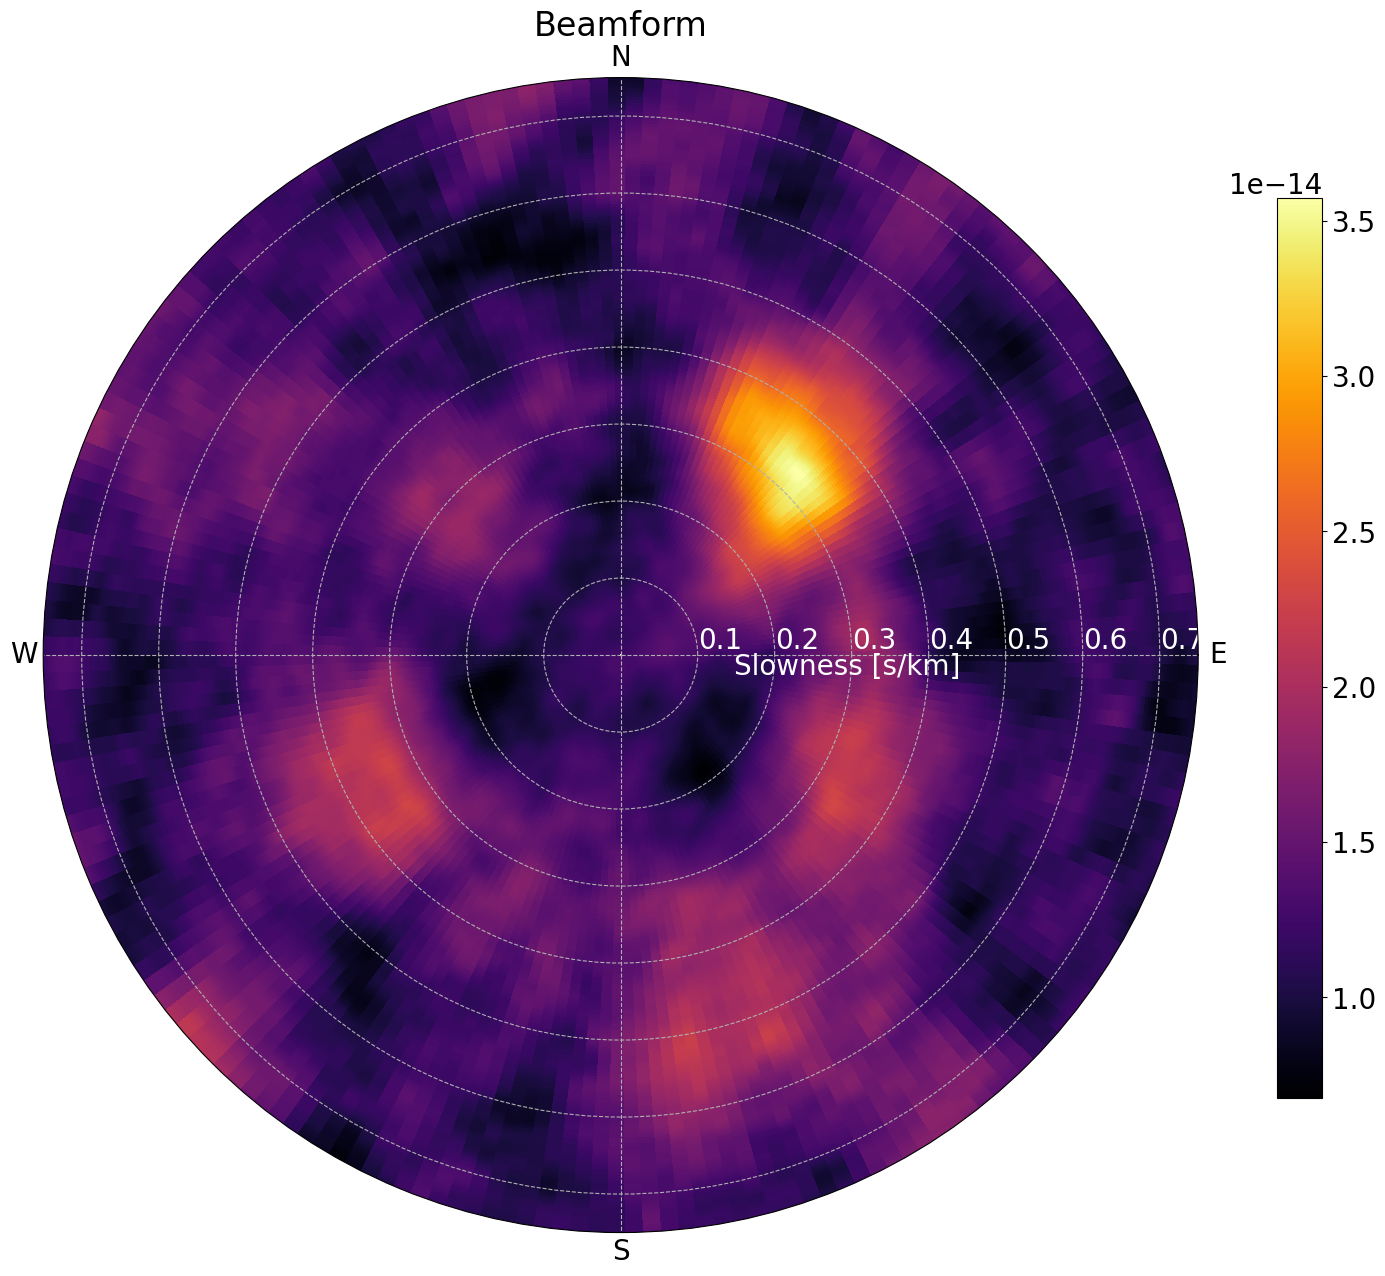

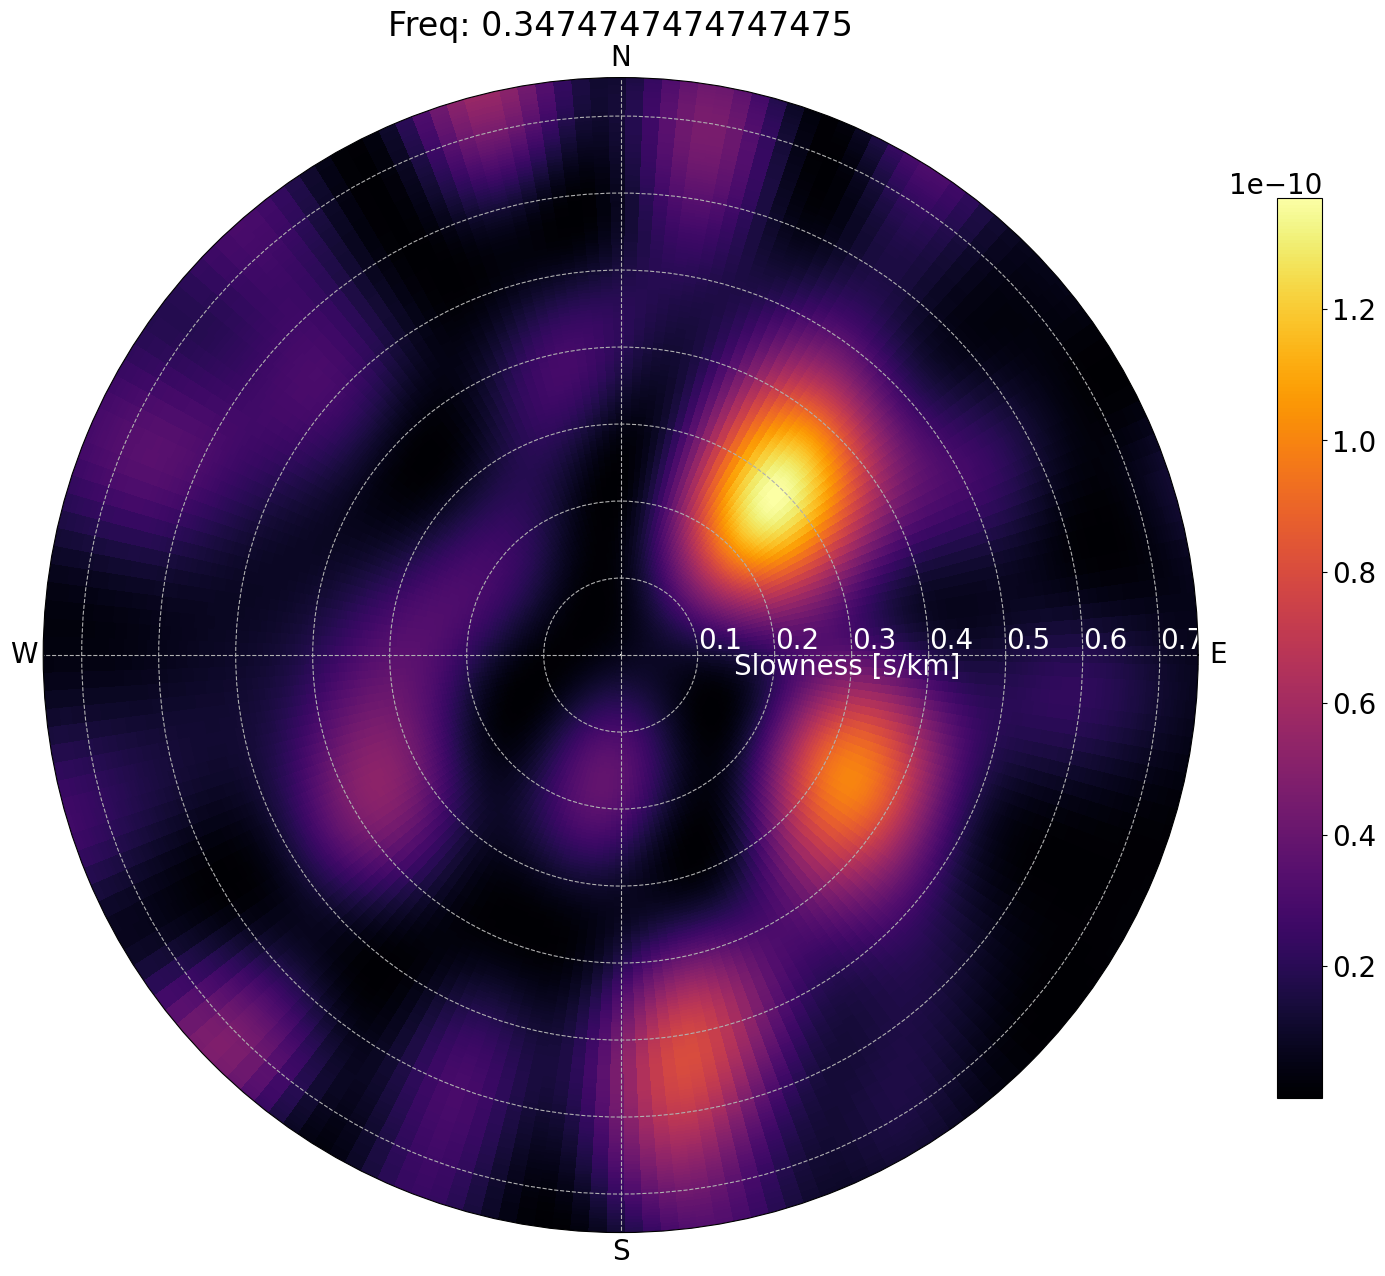

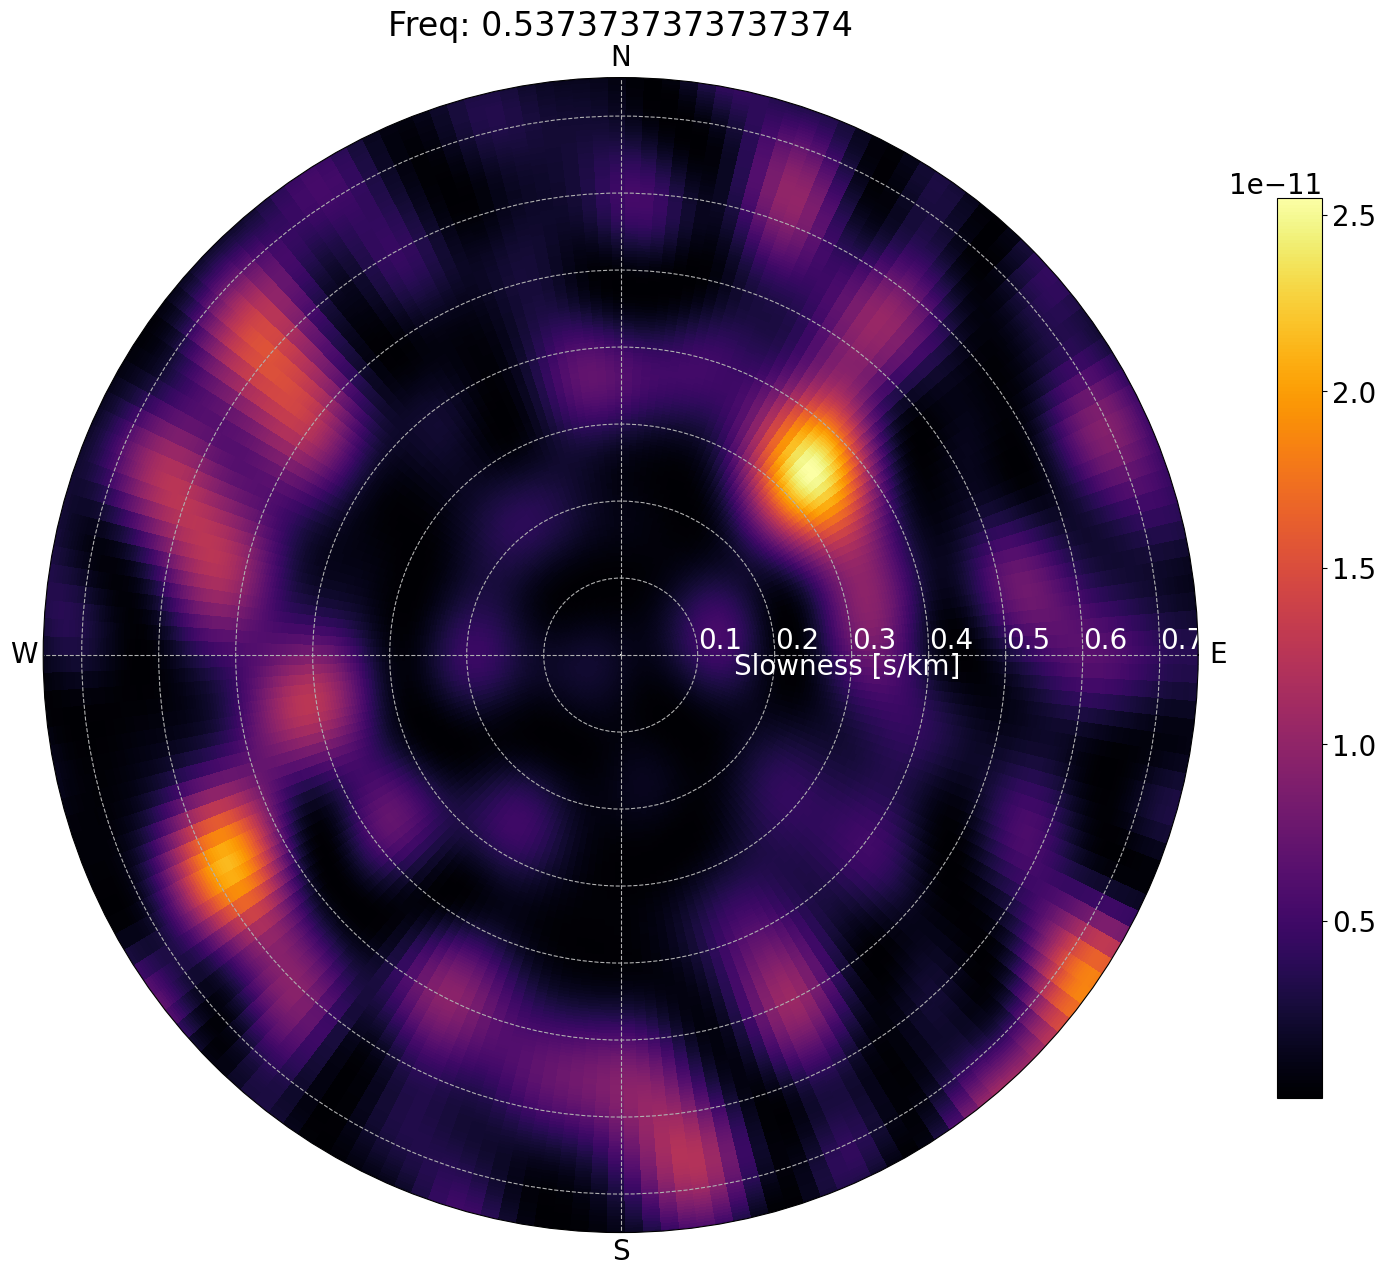

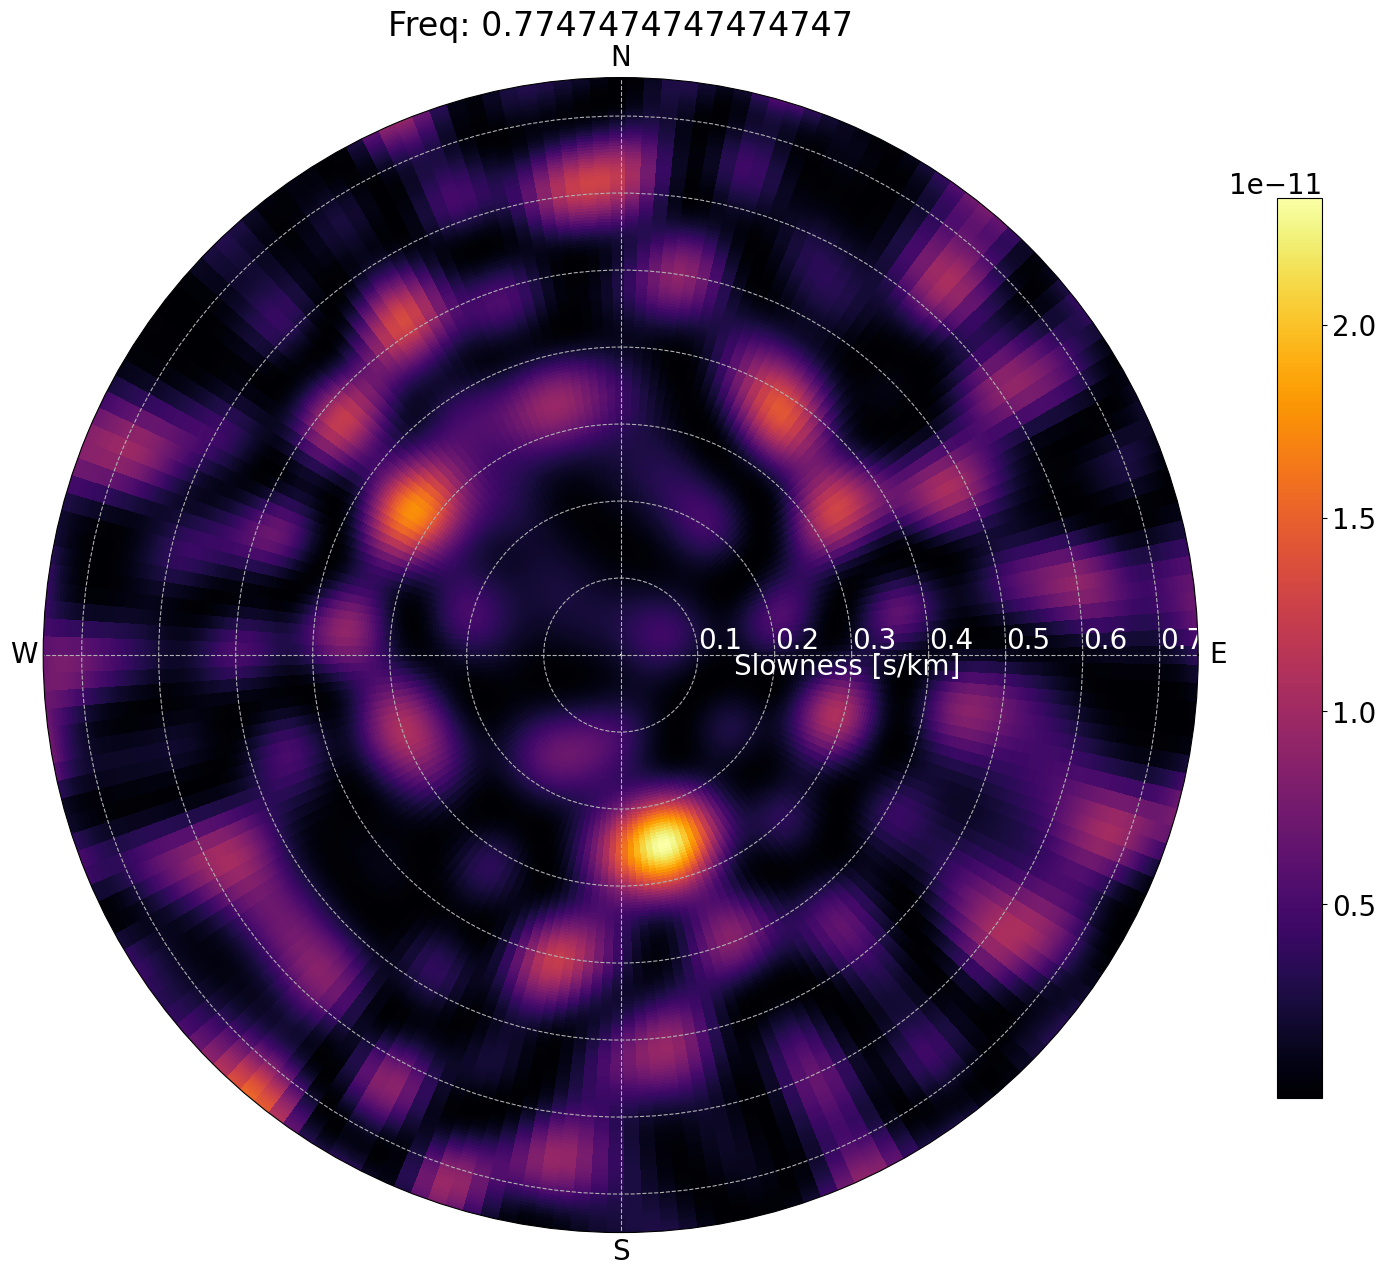

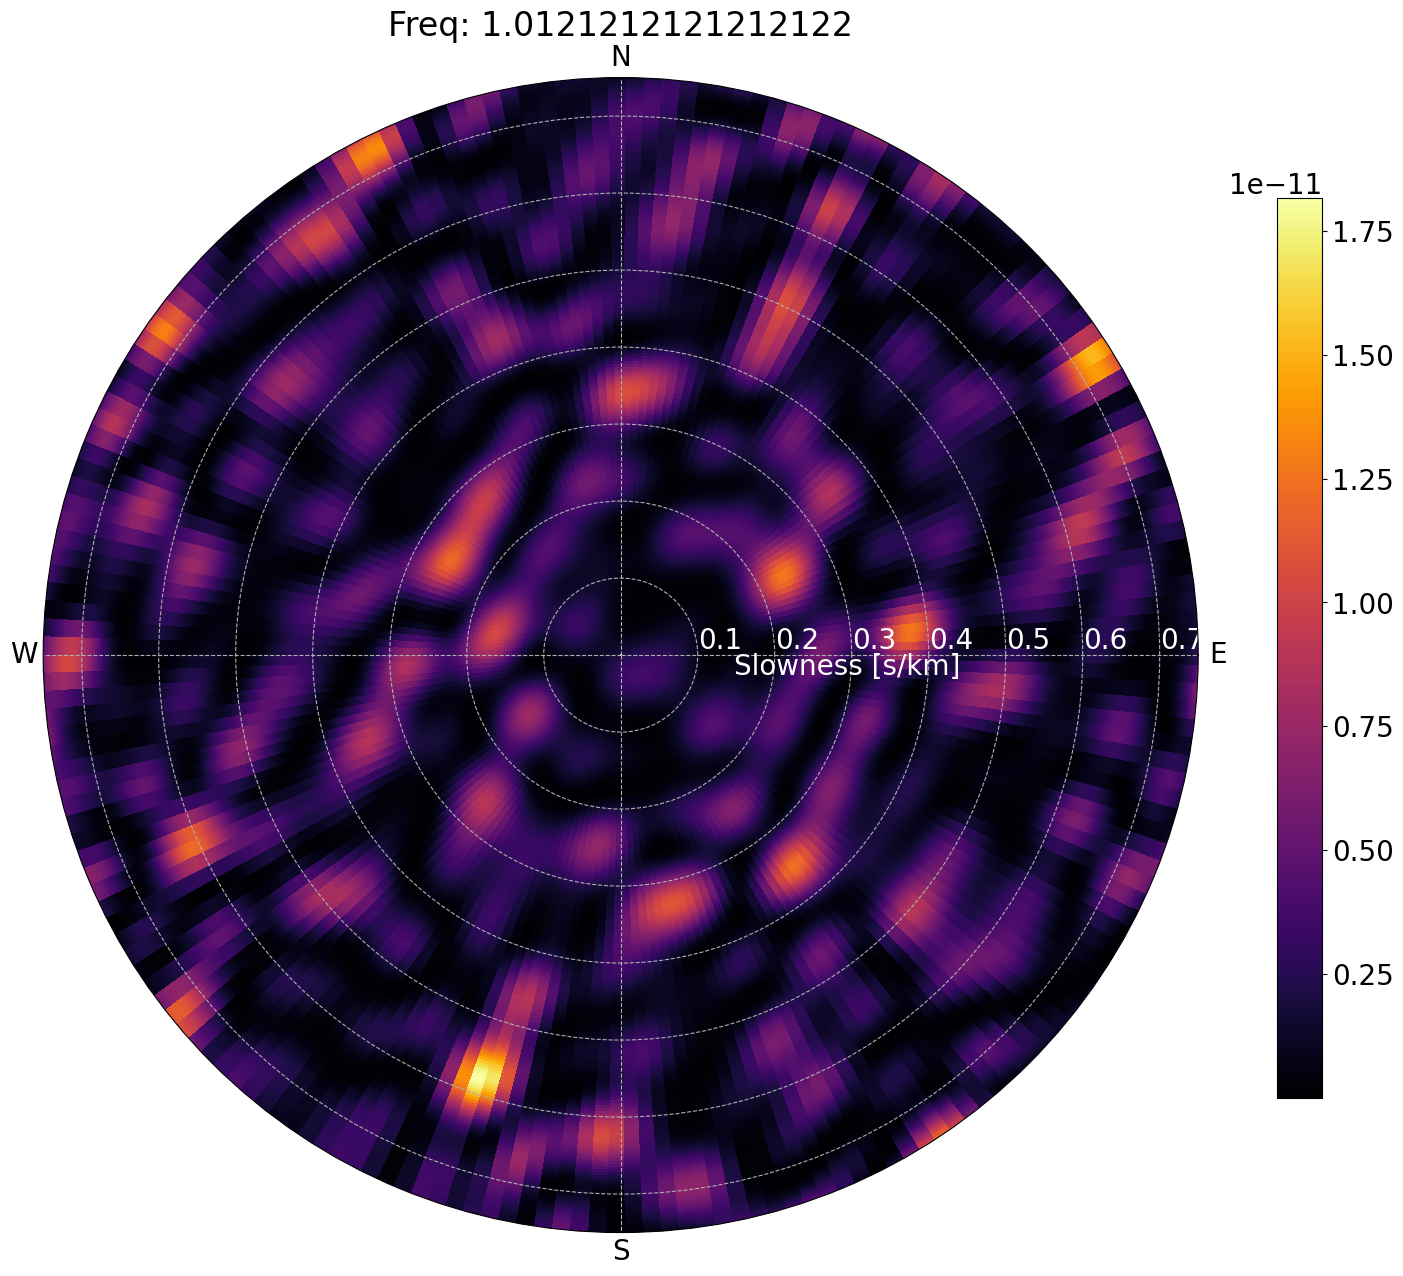

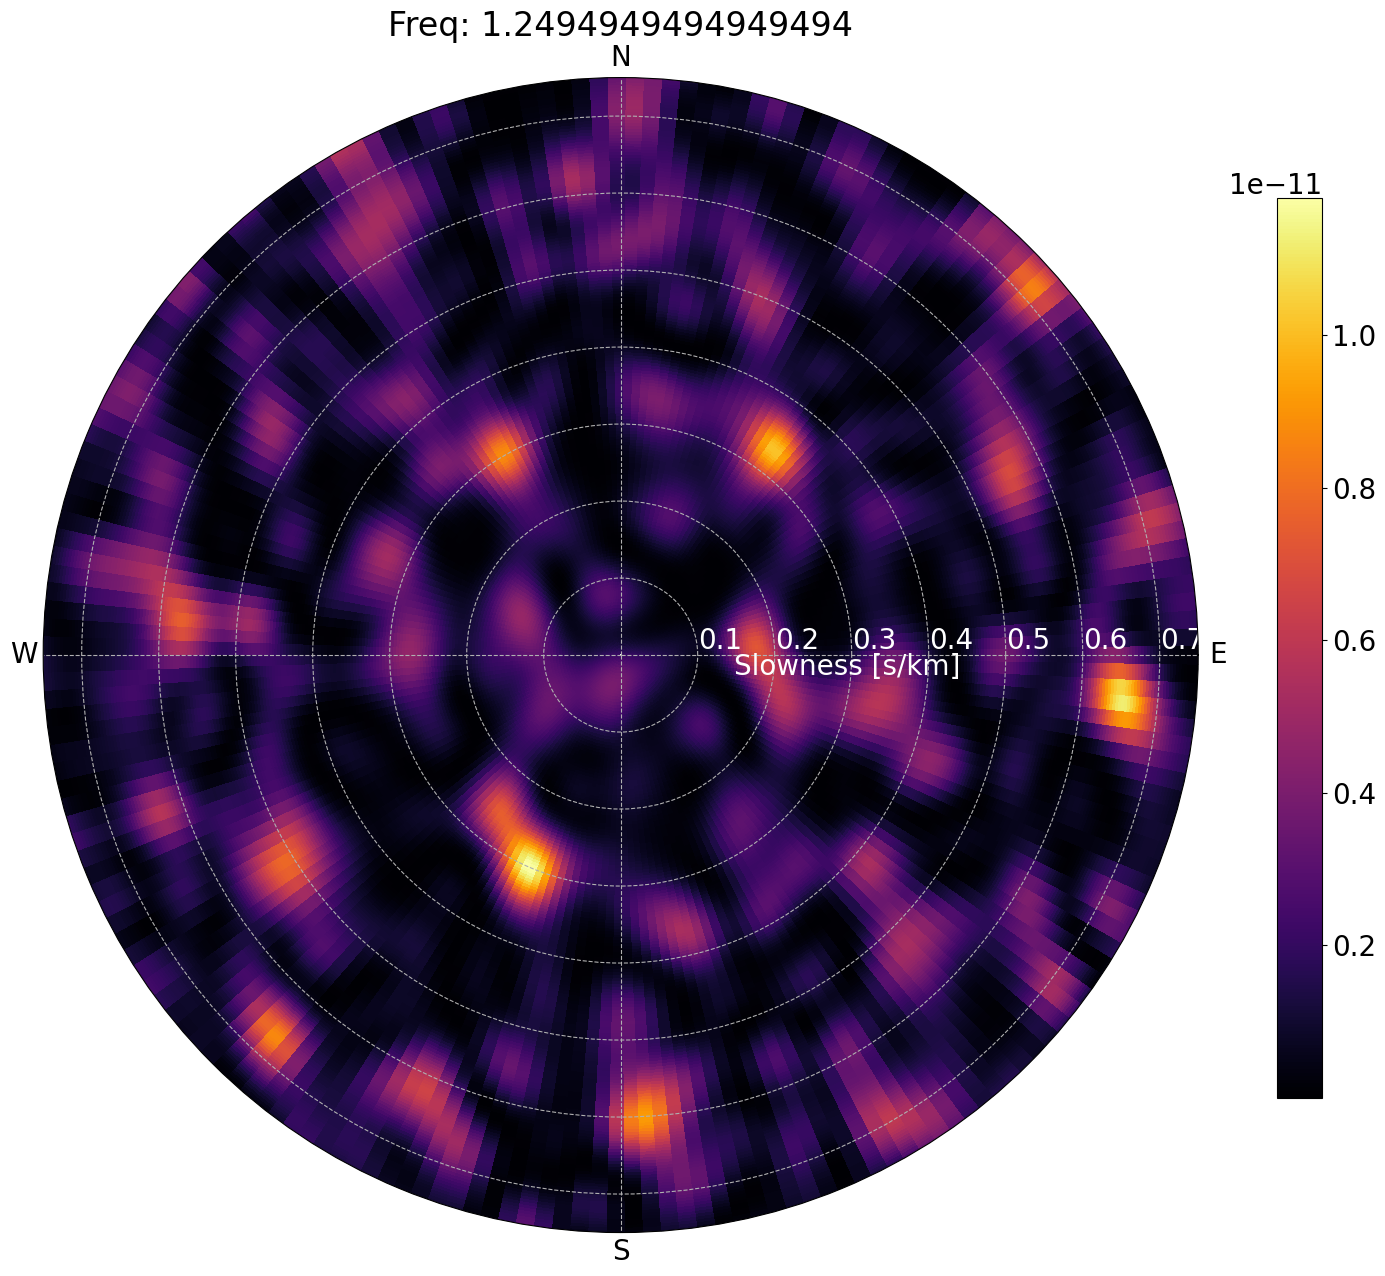

In [26]:

plot_beam_polar(P_stack,title="Beamform", save=0, savename="1c_polar_freq.pdf")

for ii in [1, 5, 10, 15, 20]:
    plot_beam_polar(np.real(P[ii,:,:]),title="Freq: {0}".format(target_freqs[ii]), save=0, savename="1c_polar_freq_{0}Hz.pdf".format(target_freqs[ii]))